## False Coloring Introduction 


#### Purpose
Render grayscale digital pathology datasets into virtual H&E color space for 3D pathology. This notebook is used to describe some of the main features of the FalseColor python package, and view the results. The main processing application of this package is color_script.py located in the scripts folder. 

#### Using this notebook

##### CPU processing
1. A dataset from the Examples/h5_sample_data folder is loaded into a DataObject class for parallel processing
2. A runnable dictionary is created which contains a 'runnable' (method) fc.falseColor, and 'kwargs' (None in this case) which will be passed to the DataObjects processImages method. The purpose of this is to have an object which possesses abstracted processing method which could apply any user-defined image processing operation in a generalized form.
3. The data is false colored using the falseColor method from coloring.py

##### GPU processing
With GPU processing there are a few more pre processing steps that occur, which happen implicitly in the CPU version.
NOTE: for using the non-flat field based fc.rapidFalseColor method additional background subtraction is unneeded.
1. Background levels are calculated and subtracted from both channels and image levels are clipped to the range of 0-65535.
2. Edges are enhanced using the sharpenImage method in coloring.py
3. The intensity leveling map for each channel is calculated and resized 
4. The images are false colored using the rapidFalseColor method from coloring.py

In [ ]:
import falsecolor.coloring as fc
from falsecolor.dataobject import DataObject
import numpy as np
import os
%matplotlib notebook
import matplotlib.pyplot as plt
from falsecolor.process import ViewImage
import h5py as h5
import scipy.ndimage as nd
import skimage as sk
import copy

## CPU Processing

### DataObjects

A DataObject is a class in FalseColor Python which can hold data in memory and process that data in parallel. It is initialized with a filepath containing the image data of interest, and a number of cpu cores for parallel processing, default is 2.

DataObjects store image data in their imageSet property, which organizes multichannel data into one array. 

In [2]:
#load data in ./h5_sample_data/example_data.h5
file_path = os.path.join(os.getcwd(),'h5_sample_data/prostate')

#setup DataObject with hdf5 imageSet

Dataset = DataObject(directory = file_path) #initialize DataObject with directory set to file_path

Dataset.setupH5data() #find h5 file stored in directory and load data

print(Dataset.imageSet.shape) #display imageset shape: CZXY

(2, 16, 1024, 1024)


<IPython.core.display.Javascript object>


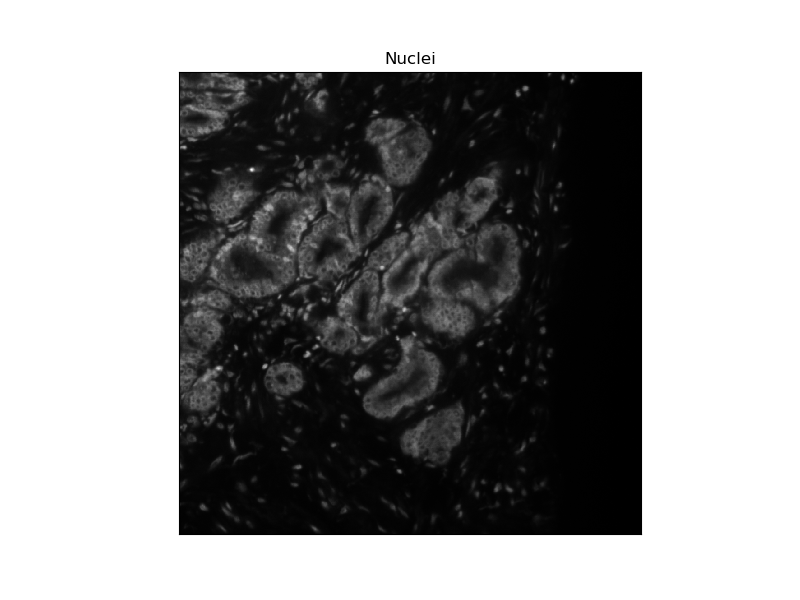

<IPython.core.display.Javascript object>


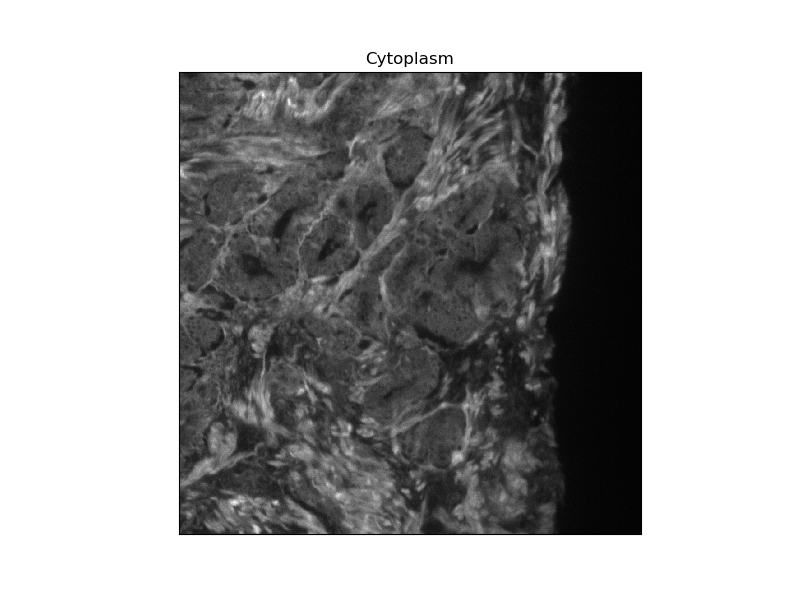

(<Figure size 800x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c300954340>)

In [3]:
#view raw data
ViewImage(Dataset.imageSet[0,0,:,:], title = 'Nuclei', cmap = 'gray', figsize = (8,6))
ViewImage(Dataset.imageSet[1,0,:,:], title = 'Cytoplasm', cmap = 'gray', figsize = (8,6))

### Parallel Processing

DataObjects can run general image processing functions in parallel via the processImages method. processImages takes a 'runnable' as an argument, which is a dictionary containing a python method, and the keyword arguments, along with the images to process.

In [5]:
#create runnable for CPU processing
runnable_dict = {'runnable' : fc.falseColor, #method to run in parallel, in this case the falseColor method from coloring
                 'kwargs' : None}

sharpen_dict = {'runnable' : fc.sharpenImage, 'kwargs' : None}

In [6]:

#run parallel processing on multiple CPU cores on the DataObject's imageSet
pseudo_colored_data = Dataset.processImages(runnable_dict,Dataset.imageSet)

<IPython.core.display.Javascript object>


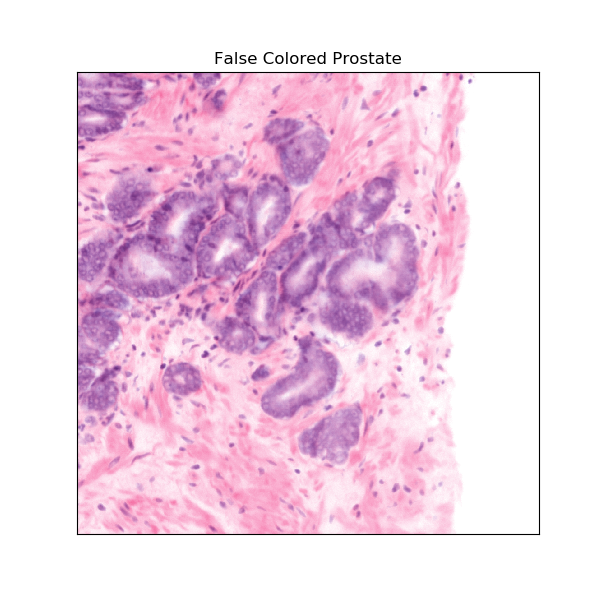

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3011d64f0>)

In [7]:
#View results
ViewImage(pseudo_colored_data[0],title='False Colored Prostate',figsize=(6,6))

## GPU Processing

In [ ]:
#Separate data into Hematoxylin (nuclei), and Eosin (cyto) 3D arrays
#This is just because the data is already in memory
nuclei = copy.deepcopy(Dataset.imageSet[0,:,:,:]).astype(float)
cyto = copy.deepcopy(Dataset.imageSet[1,:,:,:]).astype(float)
nuclei.shape

In [ ]:
#Preprocessing

#Background subtraction and sharpening
nuc_bg = fc.getBackgroundLevels(nuclei[-1])[1]
cyto_bg = fc.getBackgroundLevels(cyto[-1])[1]

#subtract background
nuclei_nobackground = copy.deepcopy(nuclei) - nuc_bg
nuclei_nobackground = np.clip(nuclei_nobackground,0,65535)

cyto_nobackground = copy.deepcopy(cyto) - 1.0*cyto_bg
cyto_nobackground = np.clip(cyto_nobackground,0,65535)

sharp_nuclei = np.zeros(nuclei_nobackground.shape)
sharp_cyto = np.zeros(cyto_nobackground.shape)

for i in range(len(nuclei_nobackground)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_nobackground[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_nobackground[i])

In [ ]:
#Calculate flat field
nuc_flatfield = fc.getFlatField(sharp_nuclei)[0]
cyto_flatfield = fc.getFlatField(sharp_cyto)[0]
print(nuc_flatfield.shape)

In [ ]:
#reshape flat field so they are the same size as image
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[0], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[0], 16, order = 1, mode = 'nearest')
print(nuc_flatfield.shape)

In [ ]:
#get RGB settings
settings_dict = fc.getDefaultRGBSettings()
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

In [ ]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
original_settings = fc.rapidFalseColor(sharp_nuclei[0], sharp_cyto[0],
                                       nuclei_RGBsettings, cyto_RGBsettings,
                                       run_FlatField_nuc = True, run_FlatField_cyto = True,
                                       cyto_normfactor = 3*cyto_flatfield,
                                       nuc_normfactor = 0.5*nuc_flatfield
                                       )

In [ ]:
ViewImage(original_settings,figsize=(6,6),title='False Colored Prostate')